# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [3]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

Upload an image of your record highs and lows plot. Ensure that your plot
includes the following elements:
---an accurate title
---correctly labelled axes
---line graph displaying record highs and lows for 2005-2014
---shaded area between the two lines
---overlaid scatter plot indicates days in 2015 that broke a record high or low for 2005-2014
---a legend or sufficient labelling for the line graph and scatter plot

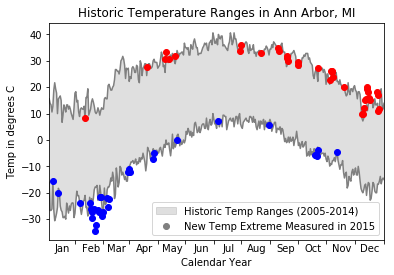

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os
import pandas as pd
import numpy as np
import datetime as datetime

# creates an ndarray of dates, creates an ndarray of just leap days, then removes leap days from the original dates
dates = np.arange('2005-01-01', '2016-01-01', dtype='datetime64[D]')
leap_days = [x for x in dates if (x.astype(object).month == 2 and x.astype(object).day > 28)]
dates = [pd.to_datetime(x).dayofyear for x in dates if x.astype(object).year == 2015]

hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/{}.csv'.format(hashid))
df.sort_values(by=['Date','ID','Element'], ascending=[True,True,False], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
for day in leap_days:
    df = df[df['Date']!=str(day)] # remove leap days from the dataframe before creating the arrays to plot
df['Year'], df['Month'], df['Day'] = df['Date'].dt.year, df['Date'].dt.month, df['Date'].dt.day

# break out highs and lows as columns
df['Highs'], df['Lows'] = df[df['Element']=='TMAX']['Data_Value'], df[df['Element']=='TMIN']['Data_Value']
df.drop(['Element','Data_Value'], axis=1, inplace=True)

# collapse highs and lows down to just the most extreme values recorded before 2015 by month and day 
df_resamp = df[df['Year']!=2015].groupby(['Month', 'Day']).agg({'Highs': 'max', 'Lows': 'min'})

# check whether a new record was set on each day in 2017
df_resamp['New-Lo'] = df[df['Year']==2015].groupby(['Month', 'Day']).agg({'Lows': 'min'})
df_resamp['New-Lo'] = np.where((df_resamp['New-Lo']<df_resamp['Lows']),df_resamp['New-Lo'],np.nan)

df_resamp['New-Hi'] = df[df['Year']==2015].groupby(['Month', 'Day']).agg({'Highs': 'max'})
df_resamp['New-Hi'] = np.where((df_resamp['New-Hi']>df_resamp['Highs']),df_resamp['New-Hi'],np.nan)

# re-index everything on 2015 dates so the new dataframe shows the past lo/hi records and whether a new one was set by day
df_resamp.reset_index(inplace=True)
df_resamp['Year'] = 2015
df_resamp['Date'] = pd.to_datetime(df_resamp[['Year','Month','Day']])
df_resamp.drop(['Year','Month','Day'], axis=1, inplace=True)
df_resamp.set_index('Date', inplace=True)
df_resamp[['Lows','Highs','New-Lo','New-Hi']] = df_resamp[['Lows','Highs','New-Lo','New-Hi']].apply(lambda x: x/10)
#print(df_resamp.head())

plt.figure()
df_resamp.plot(style=['-','-','o','o'])
plt.gca().get_children()[0].set_color('grey')
plt.gca().get_children()[1].set_color('grey')
plt.gca().get_children()[2].set_color('blue')
plt.gca().get_children()[3].set_color('red')
xax = plt.gca().xaxis
yax = plt.gca().yaxis
plt.xlabel('Calendar Year')
plt.ylabel('Temp in degrees C')
plt.title('Historic Temperature Ranges in Ann Arbor, MI')
plt.gca().fill_between(x=df_resamp.index, y1=df_resamp.Highs, y2=df_resamp.Lows, facecolor='grey', alpha=0.25)

grey_shade = mpatches.Patch(color='grey', alpha=0.25, label='Historic Temp Ranges (2005-2014)')
rec_marker = mlines.Line2D([],[],linestyle='', marker='o', color='grey', label='New Temp Extreme Measured in 2015')
plt.legend(handles=[grey_shade, rec_marker])

loc1 = mdates.MonthLocator(bymonthday=28)
xax.set_major_locator(loc1)
xticks, xticklabels = plt.xticks()
xticks = xticks[:len(xticks)-1]
xticks = np.append(xticks, np.array(16800.0))
plt.xticks(xticks)
plt.setp(plt.gca().get_xmajorticklabels(), visible=False)

loc2 = mdates.MonthLocator(bymonthday=14)
xax.set_minor_locator(loc2)
xax.set_minor_formatter(mdates.DateFormatter('%b'))
plt.gca().tick_params(axis='x', which='minor', length=0)

plt.gcf().savefig('Course2-Assignment2-Part1.png', dpi=1000)
plt.show()

# 